In [0]:
#GPU count and name
!nvidia-smi -L
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi
!lscpu |grep 'Model name'
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "L3 cache"
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"
#memory that we can use
!cat /proc/meminfo | grep 'MemAvailable'
#hard disk that we can use
!df -h / | awk '{print $4}'

GPU 0: Tesla K80 (UUID: GPU-8f961ede-3316-1dc2-3254-e0e758763bd5)
Thu Dec  5 18:33:54 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:          

In [0]:
# !git clone https://github.com/rslim087a/track
!git clone https://github.com/Jerrydepon/Track
!git clone https://github.com/Jerrydepon/AdaBound
!ls track
!pip3 install imgaug
!pip install svrg-optimizer-keras

Cloning into 'Track'...
remote: Enumerating objects: 14653, done.
remote: Counting objects: 100% (14653/14653), done.
remote: Compressing objects: 100% (14653/14653), done.
remote: Total 14653 (delta 0), reused 14653 (delta 0), pack-reused 0
Receiving objects: 100% (14653/14653), 188.15 MiB | 13.64 MiB/s, done.
Checking out files: 100% (14657/14657), done.
Cloning into 'AdaBound'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
ls: cannot access 'track': No such file or directory


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

from SVRGoptimizerKeras.optimizer import SVRG

import sys
sys.path.append('./AdaBound')
from adabound import AdaBound

Using TensorFlow backend.


Read in the data from manual training of Audacity

In [0]:
datadir = 'Track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

center  ...     speed
0  /Users/jerrywang/Desktop/self-driving_car/Final Project/data/IMG/center_2019_08_26_16_11_48_253.jpg  ...  0.000081
1  /Users/jerrywang/Desktop/self-driving_car/Final Project/data/IMG/center_2019_08_26_16_11_48_359.jpg  ...  0.000081
2  /Users/jerrywang/Desktop/self-driving_car/Final Project/data/IMG/center_2019_08_26_16_11_48_467.jpg  ...  0.000081
3  /Users/jerrywang/Desktop/self-driving_car/Final Project/data/IMG/center_2019_08_26_16_11_48_572.jpg  ...  0.000082
4  /Users/jerrywang/Desktop/self-driving_car/Final Project/data/IMG/center_2019_08_26_16_11_48_675.jpg  ...  0.000082

[5 rows x 7 columns]

In [0]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2019_08_26_16_11_48_253.jpg  ...  0.000081
1  center_2019_08_26_16_11_48_359.jpg  ...  0.000081
2  center_2019_08_26_16_11_48_467.jpg  ...  0.000081
3  center_2019_08_26_16_11_48_572.jpg  ...  0.000082
4  center_2019_08_26_16_11_48_675.jpg  ...  0.000082

[5 rows x 7 columns]

                                  center  ...      speed
0     center_2019_08_26_16_11_48_253.jpg  ...  0.000081 
1     center_2019_08_26_16_11_48_359.jpg  ...  0.000081 
2     center_2019_08_26_16_11_48_467.jpg  ...  0.000081 
3     center_2019_08_26_16_11_48_572.jpg  ...  0.000082 
4     center_2019_08_26_16_11_48_675.jpg  ...  0.000082 
...                                  ...  ...       ... 
4880  center_2019_08_26_16_20_38_448.jpg  ...  30.190320
4881  center_2019_08_26_16_20_38_552.jpg  ...  30.189410
4882  center_2019_08_26_16_20_38_653.jpg  ...  30.190790
4883  center_2019_08_26_16_20_38_768.jpg  ...  30.190550
4884  center_2019_08_26_16_20_38_874.jpg  ...  30.190520

[4885 rows x 7 columns]


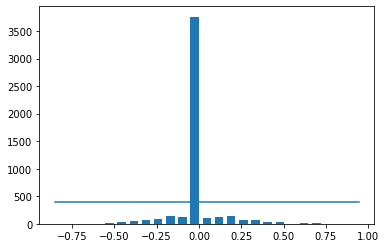

In [0]:
print(data)
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Balance the data by removing data with steering count exceeding the limit

In [0]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 4885
removed: 3359
remaining: 1526


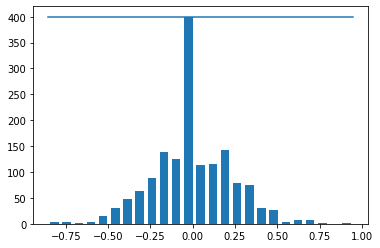

In [0]:
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Load steering data

In [0]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir, left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_08_26_16_11_51_485.jpg
left        left_2019_08_26_16_11_51_485.jpg  
right       right_2019_08_26_16_11_51_485.jpg 
steering    0                                 
throttle    1                                 
reverse     0                                 
speed       14.7098                           
Name: 31, dtype: object


Split into training & validation set (sklearn)

Training Samples: 3662
Valid Samples: 916


Text(0.5, 1.0, 'Validation set')

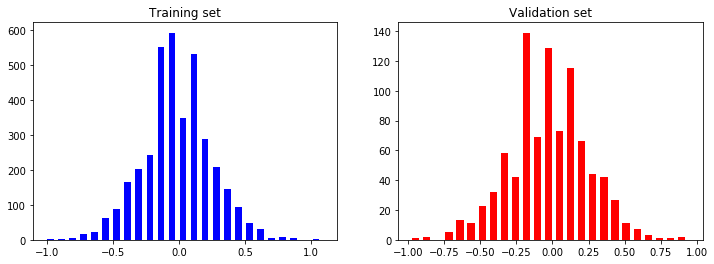

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Preprocessing images (using "augmenters" from "imgaug" library)

Text(0.5, 1, 'Zoomed Image')

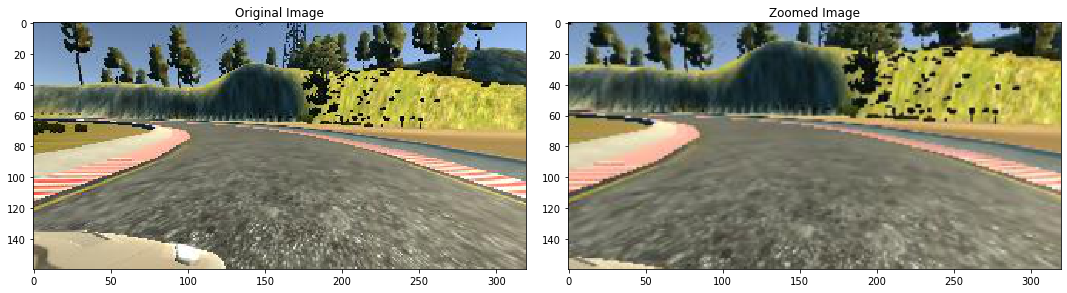

In [0]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1, 'Panned Image')

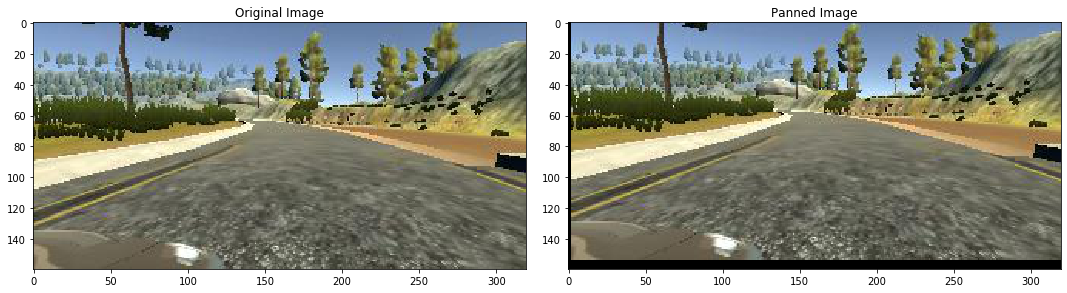

In [0]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1, 'Brightness altered image ')

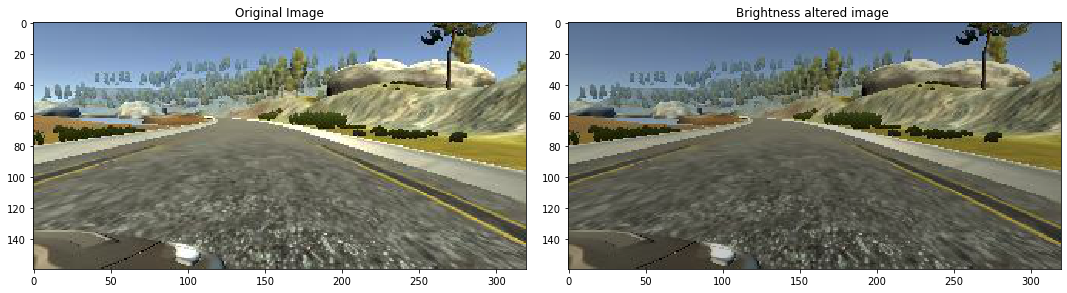

In [0]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [0]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

Text(0.5, 1, 'Flipped Image - Steering Angle:0.180336')

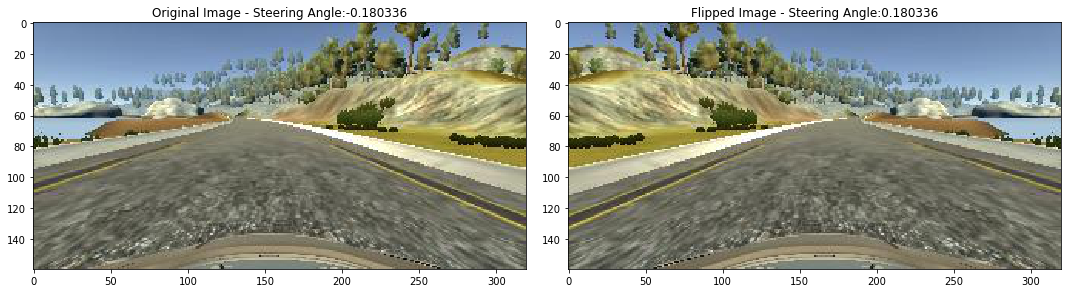

In [0]:
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

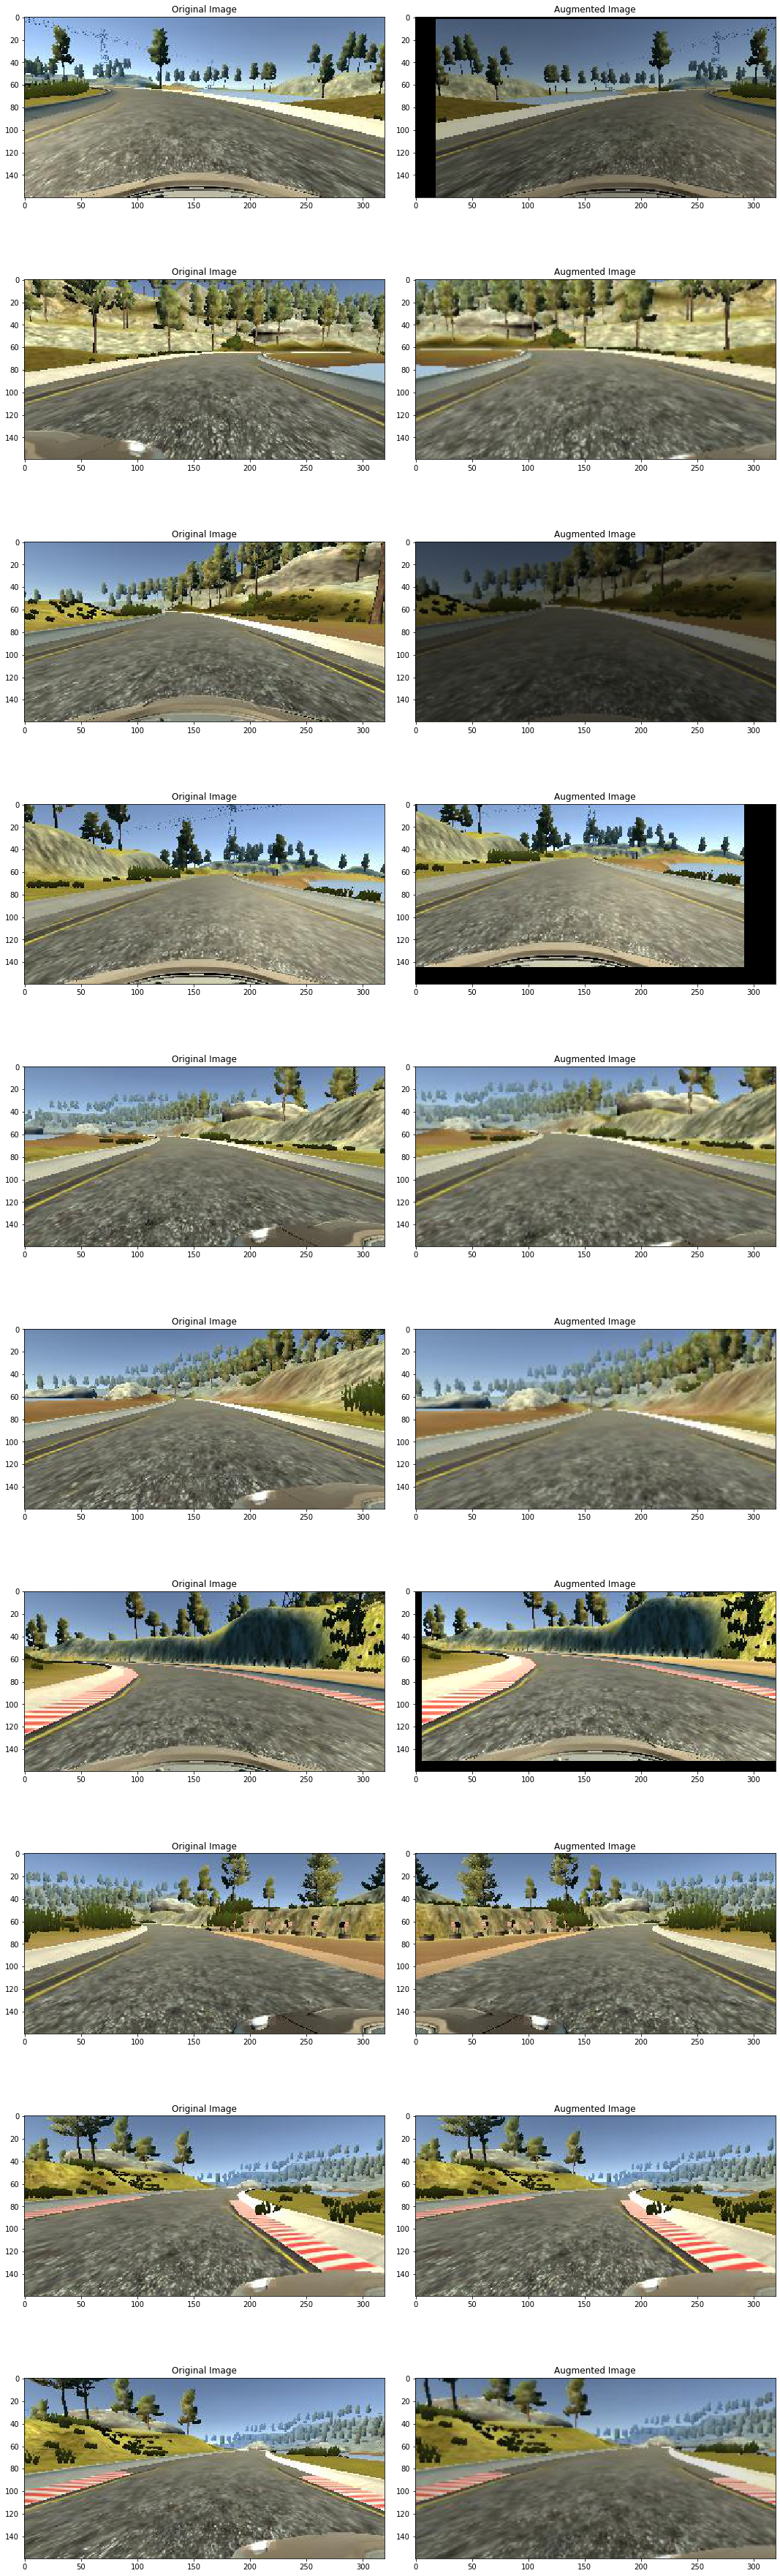

In [0]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [0]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Training Samples: 3662
Valid Samples: 916


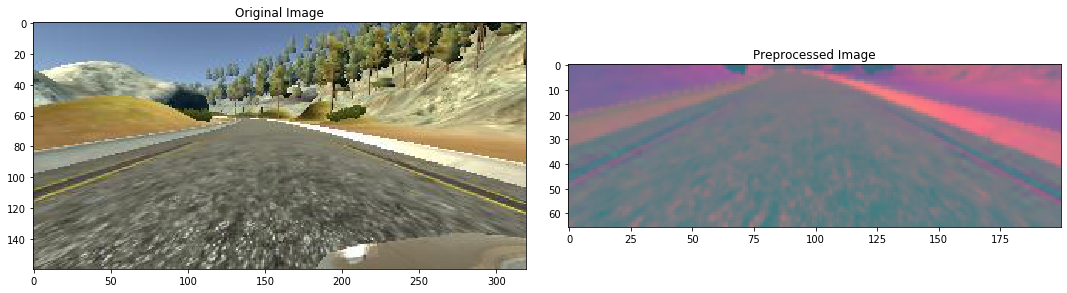

In [0]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Batch generator -- Create augmented images on the fly

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1, 'Validation Image')

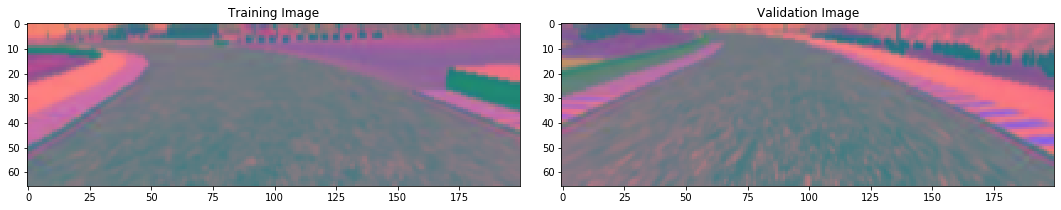

In [0]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

Train the neural network (keras)

In [0]:
def nvidia_model(optimizer):
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='elu'))
  model.add(Convolution2D(64, 3, 3, activation='elu'))
  
  model.add(Convolution2D(64, 3, 3, activation='elu'))
#   model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
#   model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
#   model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  loss = 'mse'  

  model.compile(loss=loss, optimizer=optimizer)
  return model


In [0]:
learning_rate = 5e-4

optimizer = SGD(lr=learning_rate)
model_SGD = nvidia_model(optimizer)
print('======================= SGD =======================')
print(model_SGD.summary())

optimizer = SVRG(lr=learning_rate)
model_SVRG = nvidia_model(optimizer)
print('======================= SVRG =======================')
# print(model_SVRG.summary())

optimizer = Adam(lr=learning_rate)
model_Adam = nvidia_model(optimizer)
print('======================= Adam =======================')
# print(model_Adam.summary())

optimizer = AdaBound(lr=learning_rate)
model_AdaBound = nvidia_model(optimizer)
print('======================= AdaBound =======================')
# print(model_AdaBound.summary())





======================= SGD =======================
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

======================= SVRG =======================
======================= Adam =======================
======================= AdaBound =======================


In [0]:
import timeit

epochs = 40
batch_size = 100

print('======================= SVRG =======================')
start = timeit.default_timer()
history_SVRG = model_SVRG.fit_generator(batch_generator(X_train, y_train, batch_size, 1),
                                  steps_per_epoch=300, 
                                  epochs=epochs,
                                  validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle=1)
stop = timeit.default_timer()
print('Time: ', stop - start)  
print('======================= SGD =======================')
start = timeit.default_timer()
history_SGD = model_SGD.fit_generator(batch_generator(X_train, y_train, batch_size, 1),
                                  steps_per_epoch=300, 
                                  epochs=epochs,
                                  validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle=1)
stop = timeit.default_timer()
print('Time: ', stop - start) 
print('======================= Adam =======================')
start = timeit.default_timer()
history_Adam = model_Adam.fit_generator(batch_generator(X_train, y_train, batch_size, 1),
                                  steps_per_epoch=300, 
                                  epochs=epochs,
                                  validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle=1)
stop = timeit.default_timer()
print('Time: ', stop - start) 
print('======================= AdaBound =======================')
start = timeit.default_timer()
history_AdaBound = model_AdaBound.fit_generator(batch_generator(X_train, y_train, batch_size, 1),
                                  steps_per_epoch=300, 
                                  epochs=epochs,
                                  validation_data=batch_generator(X_valid, y_valid, batch_size, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle=1)
stop = timeit.default_timer()
print('Time: ', stop - start) 

======================= SVRG =======================



Epoch 1/40





300/300 [==============================] - 228s 759ms/step - loss: 0.0676 - val_loss: 0.0745
Epoch 2/40
300/300 [==============================] - 216s 718ms/step - loss: 0.0677 - val_loss: 0.0747
Epoch 3/40
300/300 [==============================] - 215s 716ms/step - loss: 0.0669 - val_loss: 0.0728
Epoch 4/40
300/300 [==============================] - 212s 708ms/step - loss: 0.0667 - val_loss: 0.0713
Epoch 5/40
300/300 [==============================] - 214s 712ms/step - loss: 0.0665 - val_loss: 0.0702
Epoch 6/40
300/300 [==============================] - 212s 708ms/step - loss: 0.0654 - val_loss: 0.0692
Epoch 7/40
300/300 [==============================] - 213s 709ms/step - loss: 0.0650 - val_loss: 0.0711
Epoch 8/40
300/300 [==============================] - 213s 708ms/step - loss: 0.0660 - val_loss: 0.0695
Epoch 9/40
300/300 [==============================] - 211s 704ms/step - loss: 0.0642 - val_loss: 0.0668
Epo

Visulize the training result

======================= SGD =======================
======================= SVRG =======================
======================= Adam =======================
======================= AdaBound =======================


<Figure size 432x288 with 0 Axes>

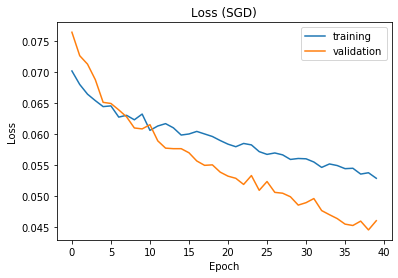

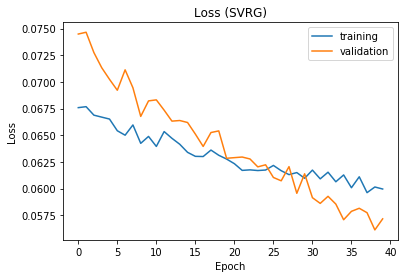

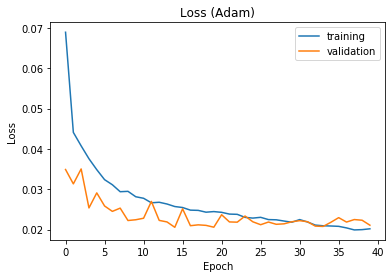

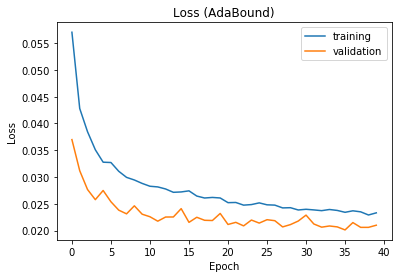

<Figure size 432x288 with 0 Axes>

In [0]:
print('======================= SGD =======================')
plt.plot(history_SGD.history['loss'])
plt.plot(history_SGD.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(0)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')
print('======================= SVRG =======================')
plt.plot(history_SVRG.history['loss'])
plt.plot(history_SVRG.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss (SVRG)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(2)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')
print('======================= Adam =======================')
plt.plot(history_Adam.history['loss'])
plt.plot(history_Adam.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(3)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')
print('======================= AdaBound =======================')
plt.plot(history_AdaBound.history['loss'])
plt.plot(history_AdaBound.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss (AdaBound)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(4)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')

======================= SGD =======================
======================= SVRG =======================
======================= Adam =======================
======================= AdaBound =======================


<Figure size 432x288 with 0 Axes>

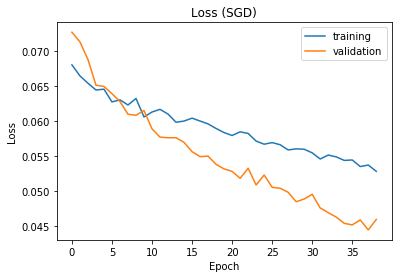

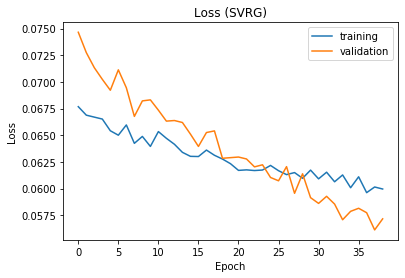

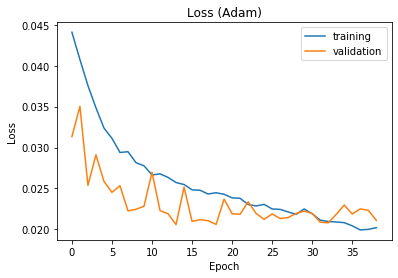

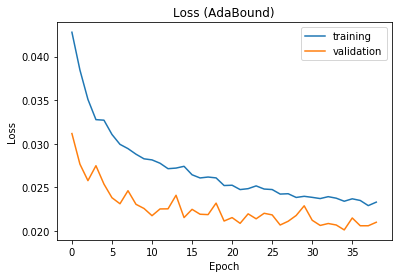

<Figure size 432x288 with 0 Axes>

In [0]:
print('======================= SGD =======================')
plt.plot(history_SGD.history['loss'][1:])
plt.plot(history_SGD.history['val_loss'][1:])
plt.legend(['training', 'validation'])
plt.title('Loss (SGD)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(0)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')
print('======================= SVRG =======================')
plt.plot(history_SVRG.history['loss'][1:])
plt.plot(history_SVRG.history['val_loss'][1:])
plt.legend(['training', 'validation'])
plt.title('Loss (SVRG)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(2)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')
print('======================= Adam =======================')
plt.plot(history_Adam.history['loss'][1:])
plt.plot(history_Adam.history['val_loss'][1:])
plt.legend(['training', 'validation'])
plt.title('Loss (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(3)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')
print('======================= AdaBound =======================')
plt.plot(history_AdaBound.history['loss'][1:])
plt.plot(history_AdaBound.history['val_loss'][1:])
plt.legend(['training', 'validation'])
plt.title('Loss (AdaBound)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(4)
# model.save('model.h5')
# from google.colab import files
# files.download('model.h5')

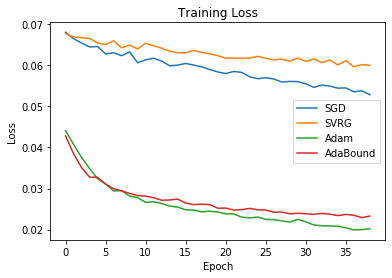

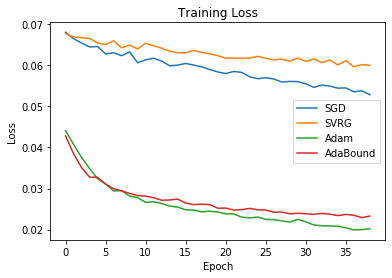

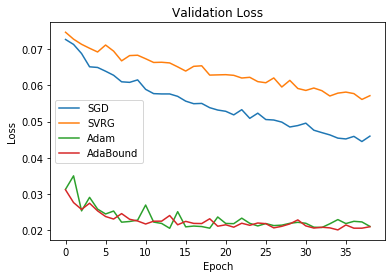

In [0]:
plt.plot(history_SGD.history['loss'][1:])
plt.plot(history_SVRG.history['loss'][1:])
plt.plot(history_Adam.history['loss'][1:])
plt.plot(history_AdaBound.history['loss'][1:])
plt.legend(['SGD', 'SVRG', 'Adam', 'AdaBound'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(0)

plt.plot(history_SGD.history['val_loss'][1:])
plt.plot(history_SVRG.history['val_loss'][1:])
plt.plot(history_Adam.history['val_loss'][1:])
plt.plot(history_AdaBound.history['val_loss'][1:])
plt.legend(['SGD', 'SVRG', 'Adam', 'AdaBound'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(1)